We train a `sklearn` Support Vector Classifier model with radial basis functions (`sklearn.svm.SVC(kernel=rbf)`), then create a Shparkley wrapper implementing the Shparkley API, then generate shapley values using Spark. We compare to `KernelShap`, the fastest black-box model explainer available from [`shap`, a leading method.](https://github.com/slundberg/shap)

This notebook shows 
1. Shparkley works with any model that can implement the wrapper class and which can generate predictions given a dataset in local (to each executor) memory.
2. Shparkley can be faster than `shap`, even on a single machine and even where `shap` is using a different approximation, by using all machine cores to generate predictions in parallel. 

# Load Spark Kernel
Using `findspark`, but many other ways exist too. See ([Installing Spark](https://spark.apache.org/downloads.html))

In [1]:
from collections import OrderedDict
from os import system
import sys
from tempfile import mktemp
from typing import Any, Callable, Dict

import findspark
findspark.init() #  Adds `pyspark` to `sys.path` at runtime
from IPython.display import display, Image
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np
import pandas as pd
import pyspark
from pyspark.sql import Row, SQLContext
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, plot_confusion_matrix
import shap

from training_data_generator import criteria_dict_to_row_values, Criterion, generate_rows_per_leaf, tree_to_leaf_row_values

Monkey-patch fix of cloudpickle for Python 3.7 
https://github.com/cloudpipe/cloudpickle/issues/305#issuecomment-529246171

In [2]:
if sys.version_info.major == 3 and sys.version_info.minor < 8:  
    import cloudpickle
    import pyspark.serializers
    pyspark.serializers.cloudpickle = cloudpickle
    print("Fixed cloudpickle for Py3.7")

Fixed cloudpickle for Py3.7


In [3]:
pyspark.__version__

'2.4.5'

In [4]:
! echo $JAVA_HOME

/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home


In [5]:
! echo $SPARK_HOME

/usr/local/opt/apache-spark/libexec


Create connection to Spark cluster

In [6]:
sc = pyspark.SparkContext(appName="shparkley_example")

## Verify it's started 

In [7]:
! jps -lvm | grep -i spark

5863 org.apache.spark.deploy.SparkSubmit pyspark-shell -Xmx1g


 `org.apache.spark.deploy.SparkSubmit pyspark-shell` is running -- looks good. 

[Look more at configuration:](https://spark.apache.org/docs/latest/cluster-overview.html)
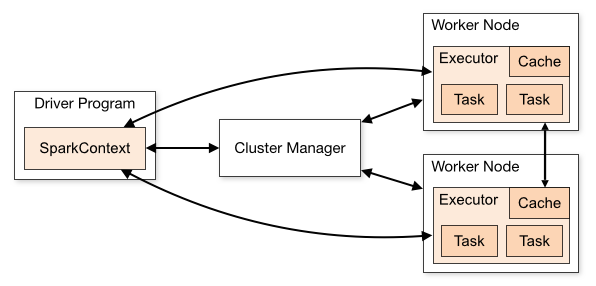

In [8]:
sc.getConf().getAll()

[('spark.app.name', 'shparkley_example'),
 ('spark.driver.port', '56598'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1604289607267'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', '192.168.1.5')]

In [9]:
sc.defaultParallelism, sc.defaultMinPartitions

(12, 2)

This means that by default, `pyspark.DataFrame`s will be created with 12 partitions. 

This is because `sc.parallelize` [here (link)](https://github.com/apache/spark/blob/97605cd1269987ed5ba3013a5f8497375ce8913e/python/pyspark/sql/session.py#L452) is used to convert from local-memory `DataFrame` which uses its `defaultParallelism`. 

There is [no obvious way](https://stackoverflow.com/a/28793407/588437) to get the number of [**executors**](https://spark.apache.org/docs/latest/cluster-overview.html) from the `pyspark` API. 


# Generate Example Dataset
We generate an example loan repayment dataset based on the simplistic assumption that whether a user repays is defined according to a simple tree with three features. 

## Create Ground Truth Tree

In [10]:
OUTCOME_NAME = 'delinquent'
graph = nx.DiGraph()
graph.add_edge(
    "fico", "loan_amount", criterion=Criterion(comparison_operator="<=", cutoff=700)
)
graph.add_edge(
    "fico", "leaf_1", criterion=Criterion(comparison_operator=">", cutoff=700)
)
graph.add_edge(
    "loan_amount", "leaf_2", criterion=Criterion(comparison_operator="<=", cutoff=1000)
)
graph.add_edge(
    "loan_amount",
    "number_of_delinquencies",
    criterion=Criterion(comparison_operator=">", cutoff=1000),
)
graph.add_edge(
    "number_of_delinquencies",
    "leaf_3",
    criterion=Criterion(comparison_operator="<=", cutoff=0),
)
graph.add_edge(
    "number_of_delinquencies",
    "leaf_4",
    criterion=Criterion(comparison_operator=">", cutoff=0),
)


graph.nodes["leaf_1"]["p_{}".format(OUTCOME_NAME)] = 0.01
graph.nodes["leaf_2"]["p_{}".format(OUTCOME_NAME)] = 0.05
graph.nodes["leaf_3"]["p_{}".format(OUTCOME_NAME)] = 0.03
graph.nodes["leaf_4"]["p_{}".format(OUTCOME_NAME)] = 0.20

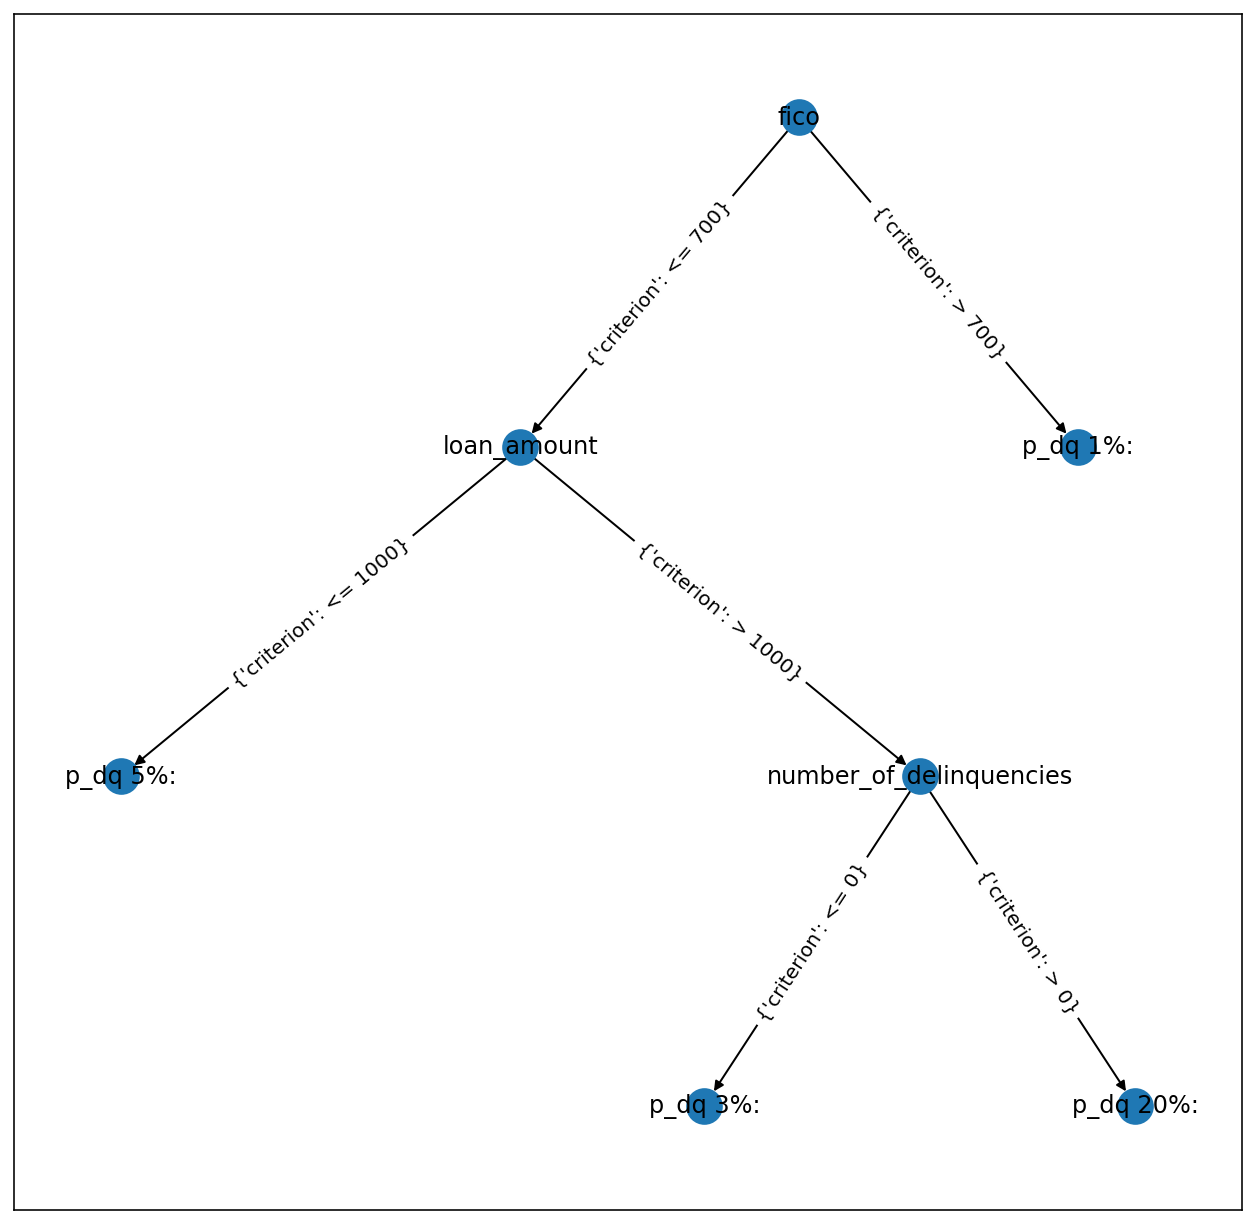

In [11]:
plt.figure(figsize=(11, 11))
labels = {
    k: "p_dq {0:.0f}%:".format(v.get("p_{}".format(OUTCOME_NAME)) * 100) if v else k
    for (k, v) in dict(graph.nodes).items()
}

positions = graphviz_layout(graph, prog="dot")
nx.draw_networkx(graph, positions, labels=labels)
_ = nx.draw_networkx_edge_labels(graph, positions)

## Generate from Tree
For each leaf node, generate data columns fitting the criteria and 1000 rows (Bernoulli with $p = $ `p_dq`)

In [12]:
DEFAULT_ROW_VALUES = {
    'fico': 350,
    'loan_amount': 1,
    'number_of_delinquencies': 0,
    'repaid_all_previous_affirm_loans': 0,
}

In [13]:
generated_loans_with_labels = generate_rows_per_leaf(
    tree=graph, default_row_values=DEFAULT_ROW_VALUES, n_per_leaf=int(1e4), outcome_name=OUTCOME_NAME, seed=42
)

In [14]:
generated_loans_with_labels[list(DEFAULT_ROW_VALUES.keys())] = generated_loans_with_labels[list(DEFAULT_ROW_VALUES.keys())].apply(pd.to_numeric)

generated_loans_with_labels.loc[:, 'delinquent_label'] = generated_loans_with_labels['delinquent_label'].astype(int)

In [15]:
generated_loans_with_labels.sample(10, random_state=47)

,fico,loan_amount,number_of_delinquencies,repaid_all_previous_affirm_loans,delinquent_label
26397,700,1001,0,0,0
2254,701,1,0,0,0
4045,701,1,0,0,0
16677,700,1000,0,0,0
6038,701,1,0,0,0
10071,700,1000,0,0,0
26218,700,1001,0,0,0
11293,700,1000,0,0,0
34754,700,1001,1,0,1
36567,700,1001,1,0,0


In [16]:
generated_loans_with_labels['delinquent_label'].value_counts()

0    37214
1     2786
Name: delinquent_label, dtype: int64

# Fit Sample Model

## Add high weights to handle unbalanced DQ

In [17]:
generated_loans_with_labels.loc[:, "weight"] = np.where(
    generated_loans_with_labels["delinquent_label"] == True, 10.0, 1.0
)

In [18]:
np.random.seed(42)
train, test = train_test_split(generated_loans_with_labels)

In [19]:
train.shape, test.shape

((30000, 6), (10000, 6))

In [20]:
svm_rbf_classifier = SVC(C=10000, probability=True)

In [21]:
np.random.seed(42)
fitted_svm_rbf_classifier = svm_rbf_classifier.fit(
    X=train.drop(["delinquent_label", "weight"], axis=1),
    y=train["delinquent_label"],
    sample_weight=train["weight"],    
)

1m 30 s to fit 

## Sanity-Check Fit

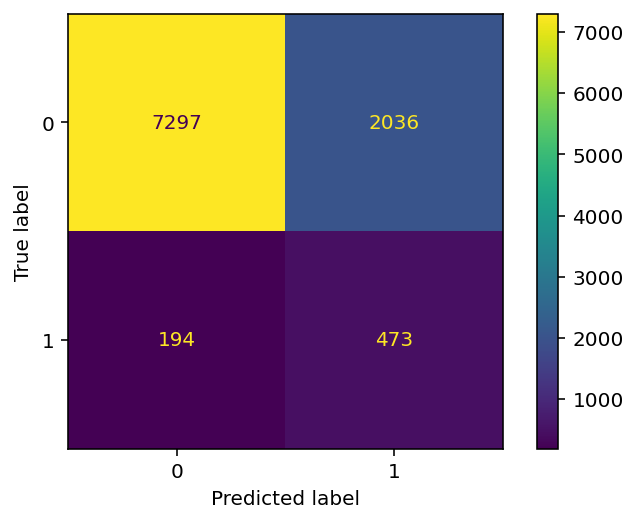

In [22]:
_ = plot_confusion_matrix(
    estimator=fitted_svm_rbf_classifier,
    X=test.drop(["delinquent_label", "weight"], axis=1),
    y_true=test["delinquent_label"],
)

In [23]:
print(
    "Precision = {:.2f}, Recall = {:.2f}, F1 = {:.2f}".format(
        precision_score(
            y_true=test["delinquent_label"],
            y_pred=fitted_svm_rbf_classifier.predict(test.drop(["delinquent_label", "weight"], axis=1)),
        ),
        recall_score(
            y_true=test["delinquent_label"],
            y_pred=fitted_svm_rbf_classifier.predict(test.drop(["delinquent_label", "weight"], axis=1)),
        ),
        f1_score(
            y_true=test["delinquent_label"],
            y_pred=fitted_svm_rbf_classifier.predict(test.drop(["delinquent_label", "weight"], axis=1)),
        ),
    )
)

Precision = 0.19, Recall = 0.71, F1 = 0.30


When taking into account sample weights, confusion matrix looks much more reasonable. 

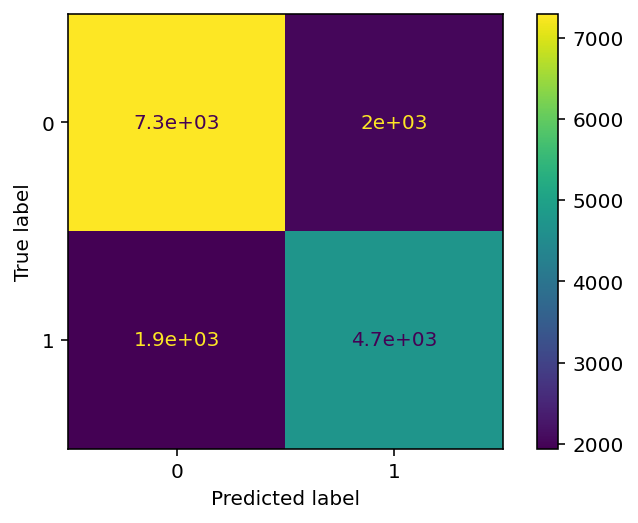

In [24]:
_ = plot_confusion_matrix(
    estimator=fitted_svm_rbf_classifier,
    X=test.drop(["delinquent_label", "weight"], axis=1),
    y_true=test["delinquent_label"],
    sample_weight=test['weight'],
)

In [25]:
print(
    "Precision = {:.2f}, Recall = {:.2f}, F1 = {:.2f}".format(
        precision_score(
            y_true=test["delinquent_label"],
            y_pred=fitted_svm_rbf_classifier.predict(test.drop(["delinquent_label", "weight"], axis=1)),
            sample_weight=test['weight'],
        ),
        recall_score(
            y_true=test["delinquent_label"],
            y_pred=fitted_svm_rbf_classifier.predict(test.drop(["delinquent_label", "weight"], axis=1)),
            sample_weight=test['weight'],
        ),
        f1_score(
            y_true=test["delinquent_label"],
            y_pred=fitted_svm_rbf_classifier.predict(test.drop(["delinquent_label", "weight"], axis=1)),
            sample_weight=test['weight'],
        ),
    )
)

Precision = 0.70, Recall = 0.71, F1 = 0.70


# Explain with Spark + Shapley

Create wrapper class. Note that within `predict`, we _cannot_ create a new distributed in-memory dataset, as this needs to be executed locally to the executor. This is a minor restriction as most models have relatively-fast inferencing, and also opens us up to use spark to accelerate the Shapley algorithm on a wide variety of existing models rather than `pyspark.mllib` and `pyspark.ml` models. If needed, spark models can be converted using [ONNX](https://github.com/onnx/onnxmltools) or similar to a model which can predict on a local executor. 

## Prep: Wrapper API

In [26]:
from typing import List

from sklearn.base import ClassifierMixin

from affirm.model_interpretation.shparkley.estimator_interface import OrderedSet, ShparkleyModel
from affirm.model_interpretation.shparkley.spark_shapley import compute_shapley_for_sample


class MyShparkleyModel(ShparkleyModel):
    def __init__(self, model: ClassifierMixin, required_features: OrderedSet):
        self._model = model
        self._required_features = required_features

    def predict(self, feature_matrix: List[OrderedDict]) -> List[float]:
        pd_df = pd.DataFrame.from_dict(feature_matrix)
        preds = self._model.predict_proba(pd_df)[:, 1]
        return preds

    def _get_required_features(self) -> OrderedSet:
        return self._required_features

In [27]:
model_with_shparkley_interface = MyShparkleyModel(
    model=fitted_svm_rbf_classifier, 
    required_features=OrderedSet(generated_loans_with_labels.columns[:4]),
)

In [28]:
model_with_shparkley_interface.get_required_features()

OrderedSet(['fico', 'loan_amount', 'number_of_delinquencies', 'repaid_all_previous_affirm_loans'])

## Explain Some Test Datapoints

### Load Training DataFrame into Spark

In [29]:
sql_context = SQLContext(sc)

train_spark_df = sql_context.createDataFrame(train)

train_spark_df.rdd.getNumPartitions()

12

~~Twelve~~ eight, as foreshadowed by earlier `defaultParallelism`

### Explain an Example Row

In [30]:
query_row = Row(fico=600, loan_amount=300, number_of_delinquencies=1, repaid_all_previous_affirm_loans=0)
query_row_df = pd.DataFrame(query_row.asDict(), index=[0])
query_row_df

,fico,loan_amount,number_of_delinquencies,repaid_all_previous_affirm_loans
0,600,300,1,0


In [31]:
query_row_prediction = fitted_svm_rbf_classifier.predict_proba(query_row_df)[0][1]
query_row_prediction

0.9999881236725682

This is predicted to be almost certainly delinquent. Why is this different from the average prediction in the training set, which is just 7% delinquent? 

In [32]:
shapley_values_shparkley = compute_shapley_for_sample(
    df=train_spark_df,
    model=model_with_shparkley_interface,
    row_to_investigate=query_row,
)
shapley_values_shparkley

{'fico': -0.00448852607255814,
 'number_of_delinquencies': 0.047115951181506216,
 'loan_amount': 0.8862127575493685,
 'repaid_all_previous_affirm_loans': 0.0}

~30s

In [33]:
mean_training_prediction = (
    fitted_svm_rbf_classifier.predict_proba(
        train.drop(["delinquent_label", "weight"], axis=1)
    )[:, 1]
).mean()
mean_training_prediction

0.07114794101425173

In [34]:
assert np.isclose(
    mean_training_prediction + sum(shapley_values_shparkley.values()),
    query_row_prediction,
    atol=1e-2,
), "Efficiency Violated"

In [35]:
shap.initjs()

In [36]:
shap.force_plot(
    base_value=mean_training_prediction,
    shap_values=np.array(list(shapley_values_shparkley.values())),
    features=np.array(list(shapley_values_shparkley.keys())),
)

### Explain, Taking Weights into Account

In [37]:
mean_training_prediction_weighted = np.average(fitted_svm_rbf_classifier.predict_proba(
    train.drop(["delinquent_label", "weight"], axis=1)
)[:, 1], weights=train['weight'])
mean_training_prediction_weighted

0.1011566139995791

In [38]:
shapley_values_shparkley_weighted = compute_shapley_for_sample(
    df=train_spark_df,
    model=model_with_shparkley_interface,
    row_to_investigate=query_row,
    weight_col_name='weight',
)

shapley_values_shparkley_weighted

{'fico': -0.0054490626234159276,
 'number_of_delinquencies': 0.03830389016350617,
 'loan_amount': 0.8659766821328987,
 'repaid_all_previous_affirm_loans': 0.0}

In [39]:
assert np.isclose(
    mean_training_prediction_weighted + sum(shapley_values_shparkley_weighted.values()),
    query_row_prediction,
    atol=1e-2,
), "Efficiency Violated"

In [41]:
shap.force_plot(
    base_value=mean_training_prediction_weighted,
    shap_values=np.array(list(shapley_values_shparkley_weighted.values())),
    features=np.array(list(shapley_values_shparkley_weighted.keys())),
)

# Compare to `shap`

In [42]:
import shap
shap.__version__

'0.36.0'

In [43]:
shap_explainer = shap.KernelExplainer(
    lambda x: fitted_svm_rbf_classifier.predict_proba(x)[:, 1],
    train.drop(["weight", "delinquent_label"], axis=1),
)

Using 30000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [44]:
shap_values = shap_explainer.shap_values(X=query_row_df, check_additivity=True)
shap_values

array([[-0.00448618,  0.88645343,  0.04687293,  0.        ]])

~ 1m30s

In [46]:
shap.force_plot(
    base_value=shap_explainer.expected_value,
    shap_values=shap_values[0],
    features=query_row_df,
)

Almost identical